In [1]:
using Plots
using PlotlyJS
using Statistics

# Question One

### parameters

In [2]:
# air properties
rho_a  = 1.225;  # air density
cp_a = 1005; # air specific heat 
V_a  = 2880; # air volume 

# fabric properties 
rho_f = 2300; # fabric density   
cp_f = 750; # fabric specific heat      
k_f = 0.8;  #   fabric thermal conductivity 
A_f = 90;  # fabric area 
T_f = 293.15; # fabric temp 
dx = 0.01;    # delta x  
th = 0.1;  # thickness of the fabric     
dt = 15; # time step 
h = 4; # convection coefficient ??

In [3]:
alpha_f = k_f /(cp_f * rho_f); # thermal diffusivity 
lambda = alpha_f * dt / dx^2; # somehow Δt/Δx²

### fabric temperature matrix, indoor temperature vector 

In [4]:
x = range(0, th, step = dx)  |> collect  # fabric, discretize in x direction 
# t =range(0, dt*4*60*24*4, step = dt) |> collect   # 
t= range(0, 4*24*60*60, step = 15)  |> collect # timing, in seconds but why times 4 -> 4 days vs 1?
T = zeros(length(x),length(t));  # Initialize temperature matrix, [11 * 23041] -> or [10 * 23040]
n = length(x);  

In [5]:
# here T_int is determined by energy balance equation 
T_int = zeros(1,length(t)); ## TODO note the change -> in hw7 sol, it is 1xn, where as here it is 1xt
T_int[1] = T_f;  # interior starts at the fabric?
T[:,1] .= T_f;


### natural ventilation vector

In [6]:
E_v = zeros(1,length(t));
for i=0:3
    night_seconds = 24*60*60*i + 7*60*60
    morning_seconds = 24*60*60*i + 19*60*60
    ix = findall(x-> night_seconds <=x<= morning_seconds, t);
    setindex!(E_v, fill(-500, length(ix)), ix); 

    # Check 
    # print("$(24*i) \n")
    # print("$(24*i + 7) \n")
    # print("$(night_seconds) \n")
    # print("$(24*i + 19) \n")
    # print("$(morning_seconds) \n")

end

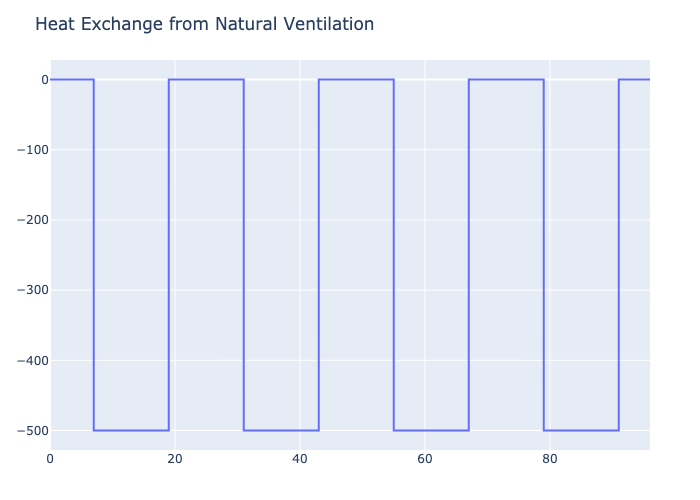

In [21]:
PlotlyJS.plot(t/3600, E_v',label="E_v", Layout(;title="Heat Exchange from Natural Ventilation", config=PlotConfig(scrollZoom=false)))

### interior heat enegy scalar

In [8]:
E_int = 250

250

## calculate temperature over time using matrix

In [9]:
beta = h *dx / k_f;

In [10]:
# construct the square A matrix
A = zeros(n,n);
for i=2:n-1
    A[i, i-1] = lambda;
    A[i, i] = 1-2*lambda;
    A[i, i+1] = lambda;
end

A[1,1] = 1-lambda-lambda*beta;  
A[1,2] = lambda;
A[n,n] = 1-lambda-lambda*beta;  
A[n,n-1] = lambda;

In [11]:
# show(IOContext(stdout, :limit=>false), MIME"text/plain"(), A);

In [12]:
size(T_int)

(1, 23041)

In [13]:
# calculate the B matrix, T matrix -- T(t+1) = A * T(t) + B
B = zeros(n,1);
E_f = zeros(length(t))
for i=1:length(t) -1
    # determine the energy of the fabric??, two sided somehow leads to 6*A_f? was it 6*A_f at some point?
    E_f[i] = h*6*A_f*(T[1,i] - T_int[i])
    T_int[i+1] = T_int[i] + dt/(rho_a*cp_a*V_a)*(h*2*3*A_f*(T[1,i]-T_int[i])+E_int+E_v[i]);
end


In [15]:
mean(E_f)

-3006.1311129867

In [16]:
mean(E_f)
E_f

23041-element Vector{Float64}:
       0.0
 -633206.2844958878
 -627422.3403792639
 -621691.2498488411
 -616012.5299294182
 -610385.7020592134
 -604810.2920495344
 -599285.8300448174
 -593811.850483031
 -588387.8920564422
       ⋮
    -249.99107377062964
    -249.9911553383668
    -249.99123616073933
    -249.99131624455833
    -249.99139559657272
    -249.99147422346974
    -249.9915521318754
    -249.9916293283554
       0.0

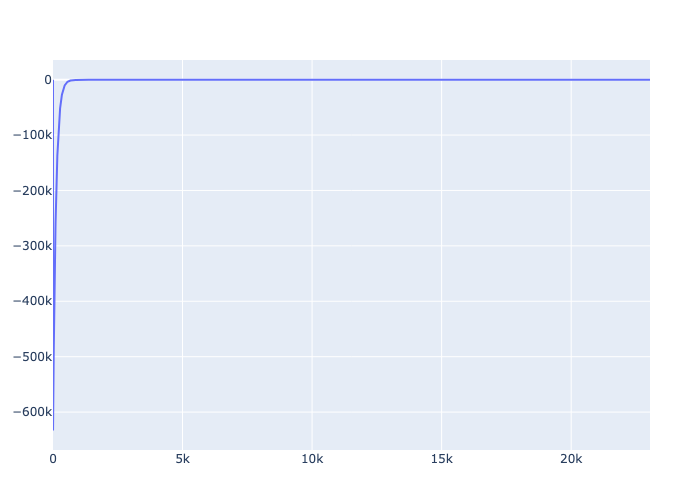

In [17]:
PlotlyJS.plot(E_f,   config=PlotConfig(scrollZoom=false))